In [175]:
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, RFE, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [176]:
# Set view options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [177]:
observation_72H_prediction_24H_48H_72H = pd.read_csv('../data/observation_72H_prediction_24H_48H_72H.csv')

np.random.seed(321)

trucks = observation_72H_prediction_24H_48H_72H[['EquipmentID']].drop_duplicates()
trucks['partition'] = np.random.randint(0, 10000, len(trucks)) / 10000
trucks['partition'] = np.where(trucks['partition'] <= 1/3, 'train',
                      np.where(trucks['partition'] <= 2/3, 'valid', 'test'))
observation_72H_prediction_24H_48H_72H = observation_72H_prediction_24H_48H_72H \
    .drop(columns = 'partition', errors = 'ignore').merge(trucks, on = 'EquipmentID')

/var/folders/gj/s4r99xvd4cl789q3qkscy9rr0000gn/T/ipykernel_81630/1411375092.py:1: DtypeWarning: Columns (3,4,8,10,11,12,14,15,16,17,21,23,24,25,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  observation_72H_prediction_24H_48H_72H = pd.read_csv('../data/observation_72H_prediction_24H_48H_72H.csv')


In [223]:
diagnostic_cols = [
    'AcceleratorPedal',
    'BarometricPressure',
    'CruiseControlActive',
    'CruiseControlSetSpeed',
    'DistanceLtd',
    'EngineCoolantTemperature',
    'EngineLoad',
    'EngineOilPressure',
    'EngineOilTemperature',
    'EngineRpm',
    'EngineTimeLtd',
    'FuelLevel',
    'FuelLtd',
    'FuelRate',
    'FuelTemperature',
    'IgnStatus',
    'IntakeManifoldTemperature',
    'LampStatus',
    'ParkingBrake',
    'Speed',
    'SwitchedBatteryVoltage',
    'Throttle',
    'TurboBoostPressure'
]

features = [
    'DistanceLtd',
    'EngineTimeLtd',
    'IntakeManifoldTemperature',
    # 'Speed',
    'Aftertreatment System',
    'Ambient Air Temperature', 'Anti-Lock Braking (ABS) Controller',
    'Auxiliary Input/Output', 'Auxiliary Temperature Sensor Input Circuit',
    'Barometric Pressure Sensor', 'Battery', 'Crankcase',
    'DAS Module to ECM Communication', 'ECU Power Output Supply Voltage',
    'Electric Lift Pump', 'Electrical Charging System Voltage',
    'Electronic Fuel Injection Control Valve',
    'Electronic Throttle Control', 'Engine Air Filter', 'Engine Brake',
    'Engine Charge Air Cooler Outlet Temperature', 'Engine Control Module',
    'Engine Coolant', 'Engine Cooling System',
    'Engine Diesel Particulate Filter', 'Engine Exhaust Back Pressure',
    'Engine Fuel', 'Engine Injector Metering Rail',
    'Engine Intake Air Heater', 'Engine Misfire', 'Engine Oil',
    'Engine Position Sensor', 
    # 'Engine Protection Torque Full Derate',
    # 'Engine Protection Torque Partial Derate', 
    'Engine Speed',
    'Engine Starter Motor Relay', 'Engine Total Idle Hours', 'Exhaust Gas',
    'Exhaust Gas Recirculation System', 'Fan Control',
    'Fuel Control Module',
    'High Pressure Common Rail Fuel Pressure Relief Valve',
    'Indicator Lamp', 'Injector Metering Rail', 'Injector Solenoid',
    'Intake Manifold', 'Intake Throttle', 'J1939 Network',
    'Real Time Clock', 'Sensor Supply', 'Steering Wheel Angle Sensor',
    'Total Vehicle Distance',
    'Transmission Communications Failure Idle Torque Limit',
    'Transmission Oil', 'Turbocharger', 'Unknown', 'Unknown (929)',
    'Unknown (829)', 'Unknown (596)', 'Unknown (50353)',
    'Unknown (2863)', 'Unknown (1068)', 'Unknown (51923)',
    'Variable Geometry Turbocharger', 'Vehicle Identification Number',
    'Wheel-Based Vehicle Speed'
]

target = 'derate_within_48hr'

In [224]:
observation_72H_prediction_24H_48H_72H

,EventTimeStamp,EquipmentID,spn,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,Unknown (1068),Unknown (2863),Unknown (50353),Unknown (51923),Unknown (596),Unknown (829),Unknown (929),partial_derate_within_24hr,full_derate_within_24hr,derate_within_24hr,partial_derate_within_48hr,full_derate_within_48hr,derate_within_48hr,partial_derate_within_72hr,full_derate_within_72hr,derate_within_72hr,DistanceLtd.1,EngineTimeLtd.1,IntakeManifoldTemperature.1,Speed.1,Aftertreatment System,Ambient Air Temperature,Anti-Lock Braking (ABS) Controller,Auxiliary Input/Output,Auxiliary Temperature Sensor Input Circuit,Barometric Pressure Sensor,Battery,Crankcase,DAS Module to ECM Communication,ECU Power Output Supply Voltage,Electric Lift Pump,Electrical Charging System Voltage,Electronic Fuel Injection Control Valve,Electronic Throttle Control,Engine Air Filter,Engine Brake,Engine Charge Air Cooler Outlet Temperature,Engine Control Module,Engine Coolant,Engine Cooling System,Engine Diesel Particulate Filter,Engine Exhaust Back Pressure,Engine Fuel,Engine Injector Metering Rail,Engine Intake Air Heater,Engine Misfire,Engine Oil,Engine Position Sensor,Engine Protection Torque Full Derate,Engine Protection Torque Partial Derate,Engine Speed,Engine Starter Motor Relay,Engine Total Idle Hours,Exhaust Gas,Exhaust Gas Recirculation System,Fan Control,Fuel Control Module,High Pressure Common Rail Fuel Pressure Relief Valve,Indicator Lamp,Injector Metering Rail,Injector Solenoid,Intake Manifold,Intake Throttle,J1939 Network,Real Time Clock,Sensor Supply,Steering Wheel Angle Sensor,Total Vehicle Distance,Transmission Communications Failure Idle Torque Limit,Transmission Oil,Turbocharger,Unknown,Variable Geometry Turbocharger,Vehicle Identification Number,Wheel-Based Vehicle Speed,DerateCluster_24H,DerateCluster_48H,DerateCluster_72H,FirstDerateTime_24H,FirstDerateTime_48H,FirstDerateTime_72H,DerateDeltaT_24H,DerateDeltaT_48H,DerateDeltaT_72H,partition
0,2015-05-11 13:11:20,301,639,14.4,13.92,False,0.00000,204061.8,185.0,18.0,55.1,193.6062,1145.75,3060.85,76.4,17070.79800024,2.760607,134.6,True,98.6,1279,False,0.000000,3276.75,14.4,0.58,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204061.8,3060.85,98.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,test
1,2015-05-13 08:22:32,301,596,89.6,14.4275,False,0.00000,204061.8,186.8,38.0,52.78,217.175,1257.5,3060.85,72.4,17193.373832368,6.326941,100.4,True,98.6,4351,False,0.000000,3276.75,89.6,4.64,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204061.8,3060.85,98.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,test
2,2015-05-18 09:34:05,301,3226,0.0,14.355,False,0.00000,123057.1,185,0.0,55.68,213.9688,1230.25,2413.65,50.8,17376.312978378,0,120.2,True,118.4,17407,False,63.525490,3276.75,0.0,20.3,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123057.1,2413.65,118.4,63.525490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,test
3,2015-05-21 13:57:35,301,639,12.0,14.5725,False,0.00000,124496.5,183.2,14.0,51.62,196.7,1115.5,2443.50,41.2,17577.34790995,2.311513,109.4,True,107.6,1279,False,4.364162,

In [225]:
df_train = observation_72H_prediction_24H_48H_72H[observation_72H_prediction_24H_48H_72H['partition'] == 'train'] \
    [[target] + features].reset_index(drop = True)

df_test = observation_72H_prediction_24H_48H_72H[observation_72H_prediction_24H_48H_72H['partition'] == 'test'] \
    [[target] + features].reset_index(drop = True)

df_valid = observation_72H_prediction_24H_48H_72H[observation_72H_prediction_24H_48H_72H['partition'] == 'valid'] \
    [[target] + features].reset_index(drop = True)

df_train_sample_one_tenth = pd.concat([
    df_train[df_train[target] == 0][0:int(len(df_train) / 10)], 
    df_train[df_train[target] == 1]
])

smote = SMOTE(k_neighbors = 5, random_state = 321)
X_train_smote, y_train_smote = smote.fit_resample(df_train_sample_one_tenth[features], df_train_sample_one_tenth[target])
df_train_smote = pd.concat([y_train_smote, X_train_smote], axis = 1)

df_train_oversampled = pd.concat([
    df_train[df_train[target] == 0], 
    df_train_smote[df_train_smote[target] == 1]
])

undersampler = RandomUnderSampler(random_state = 321, sampling_strategy = 0.5)
X_train_final, y_train_final = undersampler.fit_resample(df_train_oversampled[features], df_train_oversampled[target])

In [242]:
k = 26

X_train_std_scaled = StandardScaler().fit_transform(X_train_final)
X_train_std_minmax_scaled = MinMaxScaler().fit_transform(X_train_std_scaled)

chi2_KBest = SelectKBest(score_func = chi2, k = k)
chi2_KBest.fit(X_train_std_minmax_scaled, y_train_final)
chi2_KBest_features = X_train_final.columns[chi2_KBest.get_support(1)]

f_classif_KBest = SelectKBest(score_func = f_classif, k = k)
f_classif_KBest.fit(X_train_std_minmax_scaled, y_train_final)
f_classif_KBest_features = X_train_final.columns[f_classif_KBest.get_support(1)]

RFE_KBest = RFE(estimator = LogisticRegression(max_iter = 10000, random_state = 321), n_features_to_select = k)
RFE_KBest.fit(X_train_std_minmax_scaled, y_train_final)
RFE_KBest_features = X_train_final.columns[RFE_KBest.get_support(1)]

KBest_features = list(set(chi2_KBest_features) | set(f_classif_KBest_features) | set(RFE_KBest_features))

/Users/rohitvenkat/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 6  7 13 14 15 17 19 30 32 38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/rohitvenkat/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [243]:
lr_pipeline = Pipeline(
    steps = [
        ('scale', StandardScaler()),
        ('logreg', LogisticRegression(max_iter = 10000, random_state = 321))
    ]
)

lr_pipeline.fit(X_train_final[features], y_train_final)

print(classification_report(df_test[target], lr_pipeline.predict(df_test[features]), zero_division = 0))
print(classification_report(df_valid[target], lr_pipeline.predict(df_valid[features]), zero_division = 0))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    181841
         1.0       0.12      0.61      0.20      5134

    accuracy                           0.87    186975
   macro avg       0.55      0.74      0.56    186975
weighted avg       0.96      0.87      0.91    186975

              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92    169636
         1.0       0.11      0.40      0.18      6985

    accuracy                           0.85    176621
   macro avg       0.54      0.64      0.55    176621
weighted avg       0.94      0.85      0.89    176621



In [244]:
lr_pipeline = Pipeline(
    steps = [
        ('scale', StandardScaler()),
        ('logreg', LogisticRegression(max_iter = 10000, random_state = 321))
    ]
)

lr_pipeline.fit(X_train_final[KBest_features], y_train_final)

print(classification_report(df_test[target], lr_pipeline.predict(df_test[KBest_features]), zero_division = 0))
print(classification_report(df_valid[target], lr_pipeline.predict(df_valid[KBest_features]), zero_division = 0))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    181841
         1.0       0.12      0.61      0.20      5134

    accuracy                           0.87    186975
   macro avg       0.55      0.74      0.56    186975
weighted avg       0.96      0.87      0.91    186975

              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92    169636
         1.0       0.11      0.41      0.18      6985

    accuracy                           0.85    176621
   macro avg       0.54      0.64      0.55    176621
weighted avg       0.94      0.85      0.89    176621



In [245]:
lr_pipeline = Pipeline(
    steps = [
        ('scale', StandardScaler()),
        ('logreg', LogisticRegression(max_iter = 10000, random_state = 321))
    ]
)

lr_pipeline.fit(X_train_final[RFE_KBest_features], y_train_final)

print(classification_report(df_test[target], lr_pipeline.predict(df_test[RFE_KBest_features]), zero_division = 0))
print(classification_report(df_valid[target], lr_pipeline.predict(df_valid[RFE_KBest_features]), zero_division = 0))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98    181841
         1.0       0.18      0.22      0.20      5134

    accuracy                           0.95    186975
   macro avg       0.58      0.60      0.59    186975
weighted avg       0.96      0.95      0.95    186975

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    169636
         1.0       0.21      0.17      0.19      6985

    accuracy                           0.94    176621
   macro avg       0.59      0.57      0.58    176621
weighted avg       0.94      0.94      0.94    176621



In [246]:
rf_pipeline = Pipeline(
    steps = [
        ('scale', MinMaxScaler()),
        ('rf_clf', RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 321))
    ]
)

rf_pipeline.fit(X_train_final[features], y_train_final)

print(classification_report(df_test[target], rf_pipeline.predict(df_test[features]), zero_division = 0))
print(classification_report(df_valid[target], rf_pipeline.predict(df_valid[features]), zero_division = 0))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97    181841
         1.0       0.20      0.47      0.28      5134

    accuracy                           0.93    186975
   macro avg       0.59      0.71      0.62    186975
weighted avg       0.96      0.93      0.95    186975

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96    169636
         1.0       0.20      0.35      0.26      6985

    accuracy                           0.92    176621
   macro avg       0.59      0.65      0.61    176621
weighted avg       0.94      0.92      0.93    176621



In [247]:
rf_pipeline = Pipeline(
    steps = [
        ('scale', MinMaxScaler()),
        ('rf_clf', RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 321))
    ]
)

rf_pipeline.fit(X_train_final[KBest_features], y_train_final)

print(classification_report(df_test[target], rf_pipeline.predict(df_test[KBest_features]), zero_division = 0))
print(classification_report(df_valid[target], rf_pipeline.predict(df_valid[KBest_features]), zero_division = 0))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    181841
         1.0       0.19      0.47      0.27      5134

    accuracy                           0.93    186975
   macro avg       0.59      0.71      0.62    186975
weighted avg       0.96      0.93      0.94    186975

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96    169636
         1.0       0.19      0.35      0.25      6985

    accuracy                           0.92    176621
   macro avg       0.58      0.65      0.60    176621
weighted avg       0.94      0.92      0.93    176621



In [248]:
rf_pipeline = Pipeline(
    steps = [
        ('scale', MinMaxScaler()),
        ('rf_clf', RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 321))
    ]
)

rf_pipeline.fit(X_train_final[RFE_KBest_features], y_train_final)

print(classification_report(df_test[target], rf_pipeline.predict(df_test[RFE_KBest_features]), zero_division = 0))
print(classification_report(df_valid[target], rf_pipeline.predict(df_valid[RFE_KBest_features]), zero_division = 0))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95    181841
         1.0       0.16      0.54      0.25      5134

    accuracy                           0.91    186975
   macro avg       0.58      0.73      0.60    186975
weighted avg       0.96      0.91      0.93    186975

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94    169636
         1.0       0.16      0.39      0.23      6985

    accuracy                           0.90    176621
   macro avg       0.57      0.65      0.59    176621
weighted avg       0.94      0.90      0.92    176621



In [288]:
data = {'feature': np.array(X_train_final[RFE_KBest_features].columns), 'importance': rf_pipeline.named_steps['rf_clf'].feature_importances_}
pd.DataFrame(data).sort_values('importance', ascending = False).reset_index(drop = True).to_csv('../data/feature_importance.csv')

In [252]:
df_valid_tp = observation_72H_prediction_24H_48H_72H.loc[observation_72H_prediction_24H_48H_72H['partition'] == 'valid'].copy()
df_valid_tp['prediction'] = rf_pipeline.predict(df_valid[RFE_KBest_features])
hours_before_derate = df_valid_tp.loc[(df_valid_tp['prediction'] == df_valid_tp['derate_within_48hr']) & (df_valid_tp['prediction'] == 1)].groupby('DerateCluster_48H')['DerateDeltaT_48H'].min().sort_values() / 60

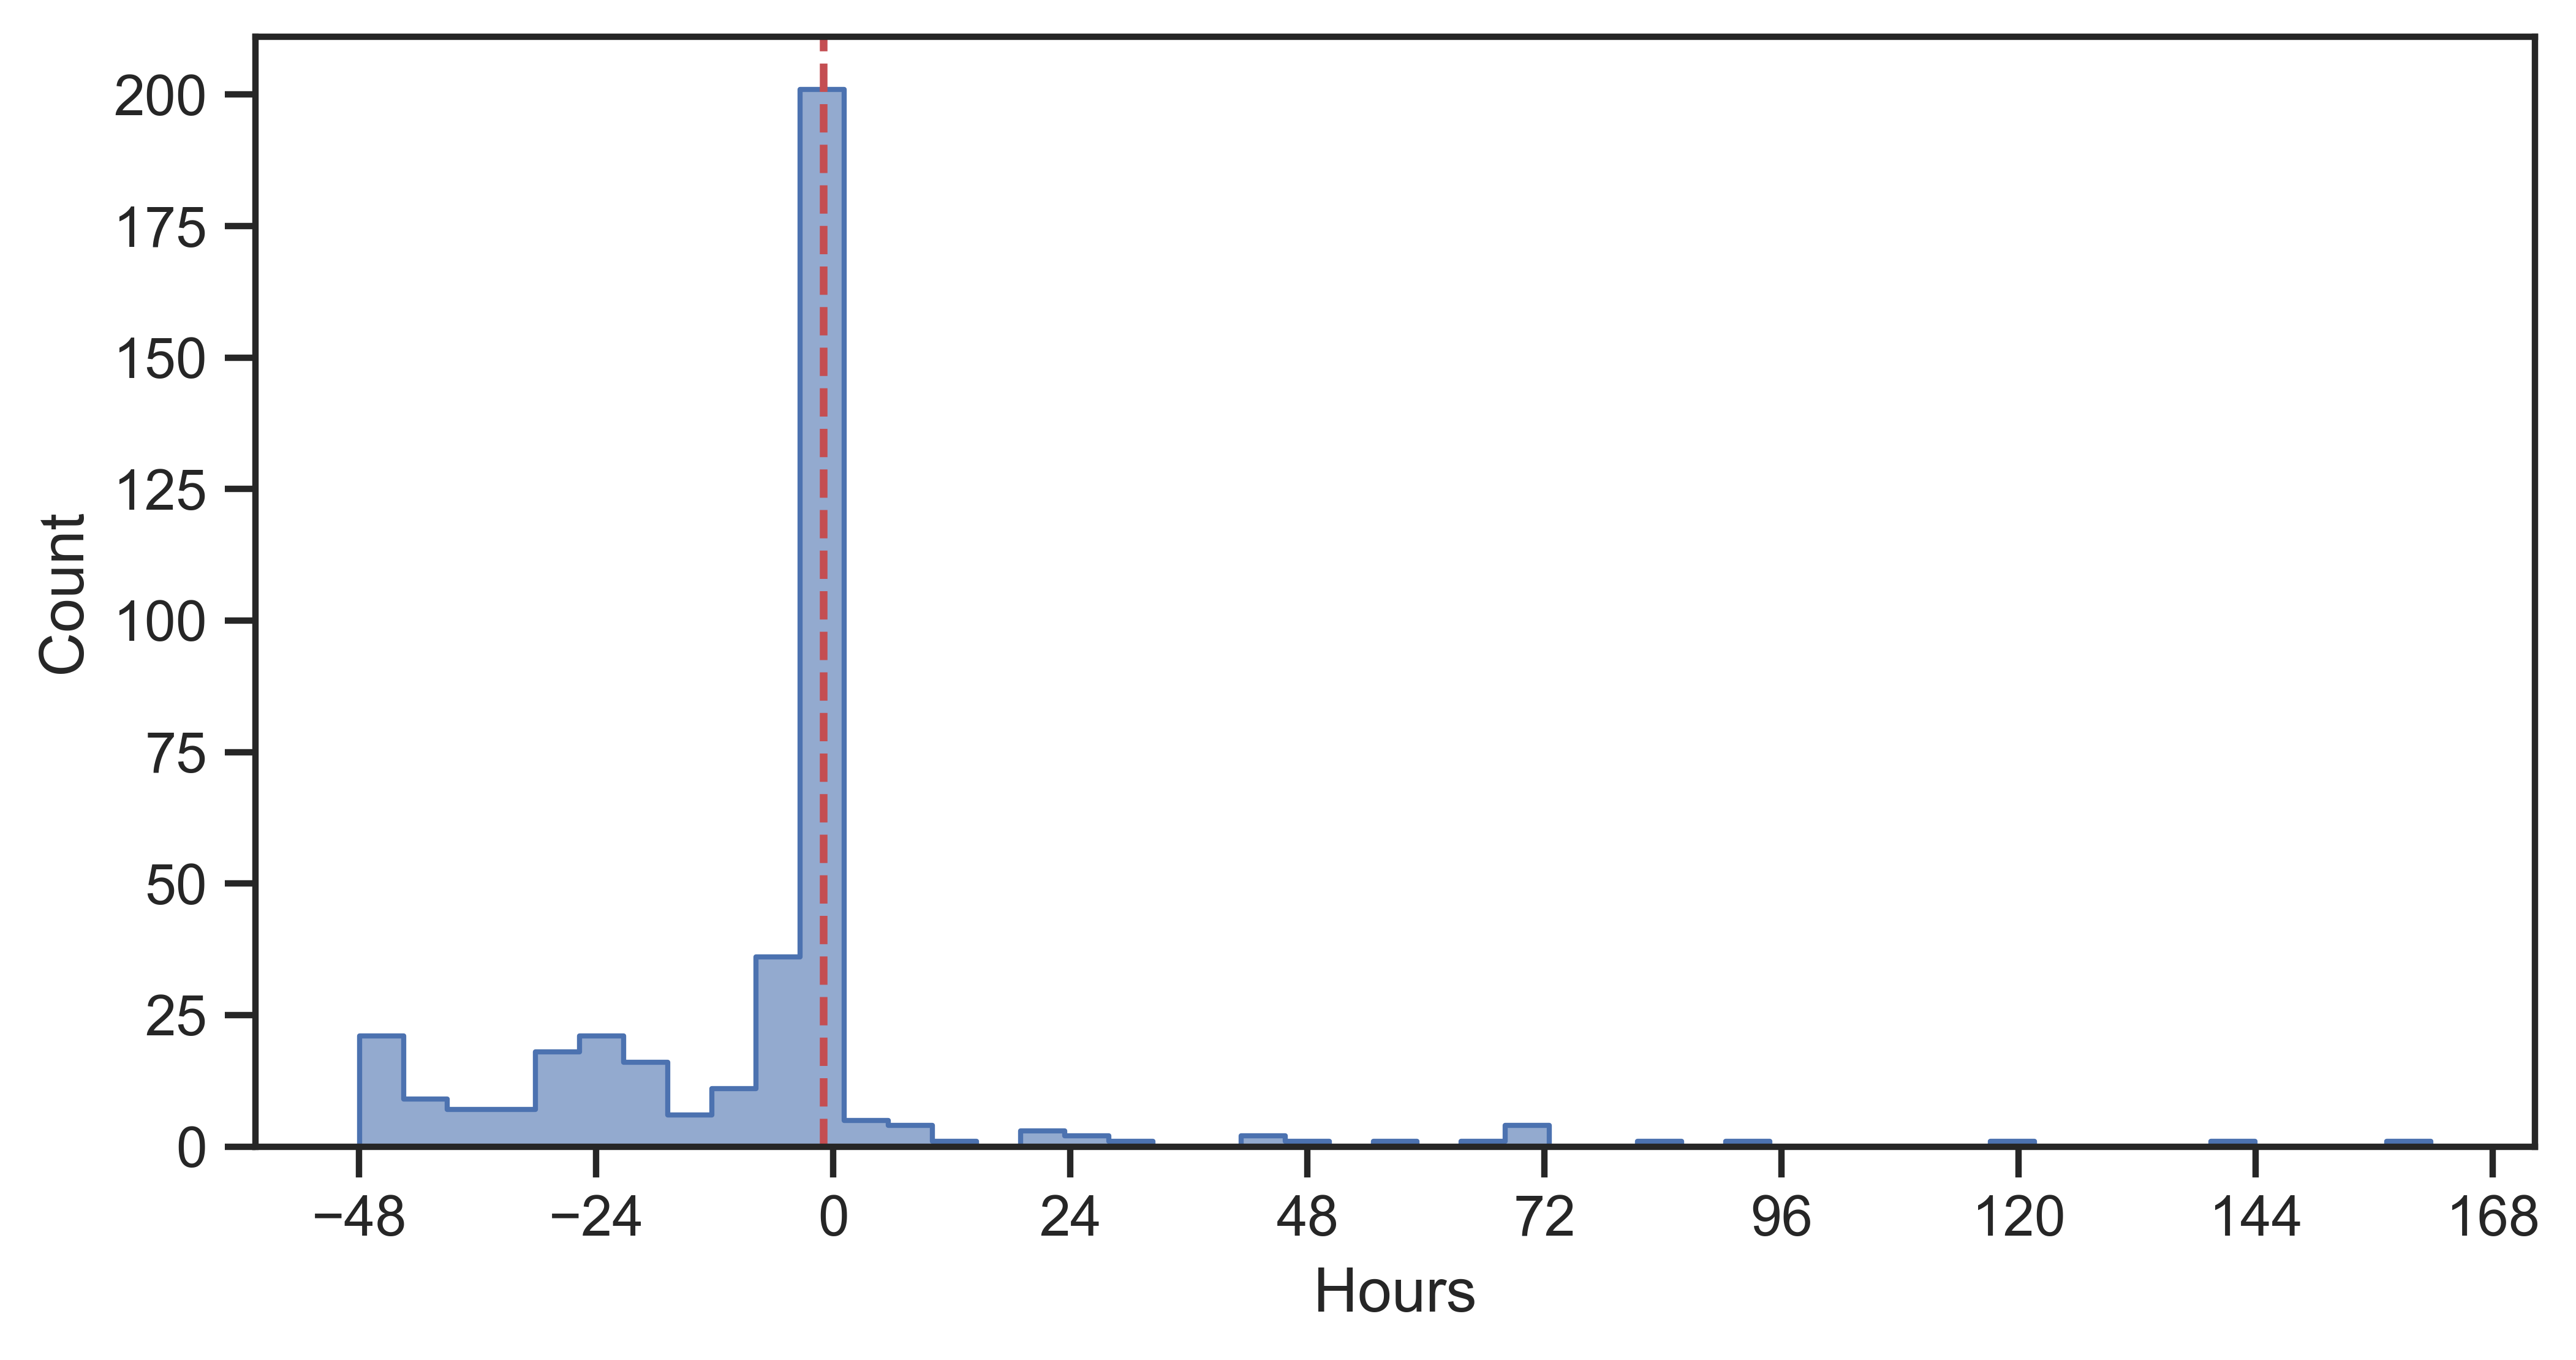

In [278]:
fig, ax = plt.subplots(figsize = (8, 4), dpi = 600)

sns.set_theme(style = 'ticks')
sns.histplot(data = hours_before_derate,
             element = 'step', alpha = 0.6);
plt.axvline(-1, color = 'r', linestyle = '--')
plt.xticks([-48,-24,0,24,48,72,96,120,144,168])
plt.xlabel('Hours')
plt.show()

In [253]:
len(hours_before_derate)

383

In [254]:
sum(hours_before_derate < -1) / len(hours_before_derate)

0.660574412532637

In [280]:
df_valid_fp = observation_72H_prediction_24H_48H_72H.loc[observation_72H_prediction_24H_48H_72H['partition'] == 'valid']
df_valid_fp['prediction'] = rf_pipeline.predict(df_valid[RFE_KBest_features])
df_valid_fp = df_valid_fp[(df_valid_fp['prediction'] != df_valid_fp['derate_within_48hr']) & (df_valid_fp['prediction'] == 1)]

/var/folders/gj/s4r99xvd4cl789q3qkscy9rr0000gn/T/ipykernel_81630/3818816696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_fp['prediction'] = rf_pipeline.predict(df_valid[RFE_KBest_features])


In [281]:
df_valid_fp['EventTimeStamp'] = pd.to_datetime(df_valid_fp['EventTimeStamp'])
df_valid_fp.groupby('EquipmentID')['EventTimeStamp'].diff().dt.days

/var/folders/gj/s4r99xvd4cl789q3qkscy9rr0000gn/T/ipykernel_81630/1471159559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_fp['EventTimeStamp'] = pd.to_datetime(df_valid_fp['EventTimeStamp'])


1463        NaN
1645      123.0
1646        2.0
1672      166.0
1847      532.0
          ...  
554574      0.0
554575      0.0
554576      3.0
554577     32.0
554853      NaN
Name: EventTimeStamp, Length: 14197, dtype: float64

In [287]:
sum(1 - (df_valid_fp.groupby('EquipmentID')['EventTimeStamp'].diff().dt.days <= 7)) / len(df_valid_fp['EquipmentID'].drop_duplicates()) / 5

1.8615384615384616

In [ ]:
mlp_pipeline = Pipeline(
    steps = [
        ('scale', MinMaxScaler()),
        ('mlp', MLPClassifier(hidden_layer_sizes = (128, 128, 128),
                              max_iter = 10000,
                              activation = 'relu',
                              learning_rate = 'adaptive',
                              solver = 'sgd',
                              tol = 0,
                              alpha = 0.1,
                              verbose = True,
                              n_iter_no_change = 20,
                              random_state = 69))
    ]
)

mlp_pipeline.fit(X_train_final, y_train_final)

In [ ]:
print(classification_report(df_test[target], mlp_pipeline.predict(df_test[features]), zero_division = 0))
print(classification_report(df_valid[target], mlp_pipeline.predict(df_valid[features]), zero_division = 0))